In [1]:
import numpy as np
import pandas as pd
from AgentClass import Agent
import const
import random
import networkx as nx
from config import number_of_bits
from scipy import stats
from collections import defaultdict
import json
import utilities
import copy

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
from random import shuffle

import analysis

from scipy.spatial import distance

In [2]:
num_agents = 100

In [3]:
def get_tau_distr():
    lower = 0.1
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = 1000

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

In [4]:
def create_environment(proportion, parameter):
        
    # bits shuffling for equal bits
    
    states = [utilities.int2bool(random.randint(0, 63), number_of_bits) for i in range(num_agents)]
    tau_distr = get_tau_distr()
    list_agents = []
    
    selected_agents = random.sample(list(range(num_agents)), int(proportion*100))
    for i in range(num_agents):
        
        if i in selected_agents:
            in_state = [0,0,0,0,0,0]
        
        else:
            in_state = [1,1,1,1,1,1]

        a = Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.watts_strogatz_graph(num_agents, 10, parameter, seed=0) # FIX THIS! change rewire parameters as from different starting, 1 means random graph as each node is going to rewired and no structure is saved
    all_edges = G.edges()

    for edge in all_edges:
        list_agents[edge[0]].add_neighbors(list_agents[edge[1]])

#     nx.draw(G, with_labels=True)
    return list_agents, G

In [5]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name,
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [6]:
def run_simulation(alpha, coherence, bit_mat, end_time, proportion, parameter):
    
    list_agents, network_graph = create_environment(proportion, parameter)

    # get network of the agents
    agent_network_df = get_network_df(list_agents)
    
    d = []
    generations = 0
    
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            soc_mat = agt.update_knowledge(alpha, coherence, bit_mat)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Number': int(agt.name.split('t')[1]),
                   'Time':t,
                   # at any time step we will need normalized how many neighbors disagree on bits
                   'bits_disagreement':np.array(agt.state_disagreements),
                   'Current_Knowledge_State':agt.knowledge_state,
                   'Current': utilities.bool2int(agt.knowledge_state),
                   'alpha':alpha,
                   'Next': utilities.bool2int(agt.next_state),
                   'Next_Knowledge_State':agt.next_state,
                   'Proportion': proportion, 
                    'Parameter': parameter}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1

    return pd.DataFrame(d), soc_mat, list_agents, network_graph

In [7]:
def hamming(a,b):
    return(bin(a^b).count("1"))

In [8]:
attrctr1 = utilities.bool2int([1,1,1,1,1,1])
attrctr2 = utilities.bool2int([0,0,0,0,0,0])

attrctrs = [attrctr1, attrctr2]
attractors = {}
number_attractors = 0
while  number_attractors< 2:
    attractor_state = attrctrs.pop()
    attractor_depth = random.randint(1, 4) # depth for each attractors is picked randomly
    attractor_radius = random.randint(1, 2)
    
    attractors[attractor_state] = {'depth': attractor_depth, 'radius': attractor_radius}
    number_attractors += 1

attrctrs_1 = [[k, 100, 1] for k,v in attractors.items()]
attrctrs_1        

[[0, 100, 1], [63, 100, 1]]

In [9]:
utilities.int2bool(31, 6)

[1, 1, 1, 1, 1, 0]

In [10]:
attrctr1

63

In [11]:
attrctr, inert, coh = analysis.init_coherence_matrix(number_of_bits, attrctrs_1, 3)

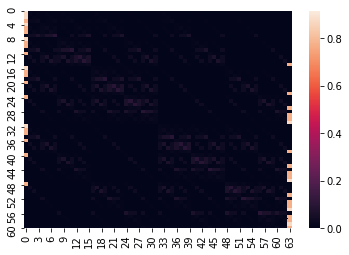

In [12]:
sns.heatmap(coh)

In [18]:
### This cell is for generating the dataset
# constants intialization

network_parameters = np.arange(0, 1, 0.1).round(2)
proportion_parameters = np.arange(0, 1, 0.1).round(2)
end_simulation_time = 100
alphas = np.arange(0, 1, 0.1).round(2)
exp_times = 1

constants = const.Constants()

bit_mat = constants.get_bit_matrix()

record_df_list = []

for alpha in alphas:
    
    for j in proportion_parameters:
        # first create environment
        
        
        for i in network_parameters:

            tmp_record_df, soc_mat, list_agents, network_graph = run_simulation(alpha, coh, bit_mat, end_simulation_time, i, j)
            tmp_record_df = tmp_record_df[tmp_record_df['Time']==99]
            record_df_list.append(tmp_record_df)
print(alpha)

Initializing matrix using bitblock method again
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [19]:
x_df = pd.concat(record_df_list)#.to_csv('results.csv', index=False)
x_df.to_csv('records_100.csv', index=False)